# Load libraries

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import h5py
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from PIL import Image
import glob
from IPython import display
import matplotlib.animation as animation
matplotlib.use("Agg")
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from PIL import Image
from IPython.display import HTML
from PIL import Image, ImageDraw
import sklearn.model_selection as sk

# Load dataset

In [ ]:
def create_dataset_from_raw(directory_path, resize_to):
    resize_width = resize_to[0]
    resize_height = resize_to[1]
    batch_names = [directory_path + name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]
    dataset = np.zeros(shape=(len(batch_names),36,resize_height,resize_width)) # (samples, filters, rows = height, cols = width)

    for batch_idx,batch in enumerate(batch_names):
        files = [x for x in os.listdir(batch) if x != '.DS_Store']
        files.sort()
        crn_batch = np.zeros(shape=(36, resize_height, resize_width)) 
        for (idx,raster) in enumerate(files):
            fn = batch + '/' + raster
            img = h5py.File(fn)
            original_image = np.array(img["image1"]["image_data"]).astype(float)
            img = Image.fromarray(original_image)
            # note that here it is (width, heigh) while in the tensor is in (rows = height, cols = width)
            img = img.resize(size=(resize_width, resize_height)) 
            original_image = np.array(img)
            original_image = original_image / 255.0
            crn_batch[idx] = original_image
        dataset[batch_idx] = crn_batch
        print("Importing batch: " + str(batch_idx))
    return dataset

def create_shifted_frames(data):
    x = data[:, 0 : 18, :, :]
    y = data[:, 18 : 36, :, :]
    return x, y

dataset = create_dataset_from_raw('./drive/MyDrive/raw/', resize_to=(315,344))
dataset = np.expand_dims(dataset, axis=-1)
dataset_x, dataset_y = create_shifted_frames(dataset)
X_train, X_val, y_train, y_val = sk.train_test_split(dataset_x,dataset_y,test_size=0.2, random_state = 42)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


# Model

In [ ]:
from keras.layers.core.dense import Dense
def create_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(7, 7),
                    input_shape=(18,344,315,1),
                    padding='same',activation=LeakyReLU(alpha=0.01), 
                    return_sequences=True))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters=64, kernel_size=(5, 5),
                    padding='same',activation=LeakyReLU(alpha=0.01), 
                    return_sequences=True))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                    padding='same',activation=LeakyReLU(alpha=0.01), 
                    return_sequences=True))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1),
                    padding='same',activation=LeakyReLU(alpha=0.01), 
                    return_sequences=True))
    model.add(BatchNormalization())
    model.add(Conv3D(filters=1, kernel_size=(3,3,3),
                activation='sigmoid',
                padding='same', data_format='channels_last'))
    return model

model = create_model()

model.compile(loss='binary_crossentropy', optimizer='adadelta')
print(model.summary())
# Define modifiable training hyperparameters.
epochs = 25
batch_size = 1

#Fit the model to the training data.
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1,
)
model.save('./drive/MyDrive/model_saved')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_10 (ConvLSTM2D)  (None, 18, 344, 315, 64)  815616   
                                                                 
 batch_normalization_10 (Bat  (None, 18, 344, 315, 64)  256      
 chNormalization)                                                
                                                                 
 conv_lstm2d_11 (ConvLSTM2D)  (None, 18, 344, 315, 64)  819456   
                                                                 
 batch_normalization_11 (Bat  (None, 18, 344, 315, 64)  256      
 chNormalization)                                                
                                                                 
 conv_lstm2d_12 (ConvLSTM2D)  (None, 18, 344, 315, 64)  295168   
                                                                 
 batch_normalization_12 (Bat  (None, 18, 344, 315, 64)

# Predict values

1/1 [==============================] - 0s 262ms/step


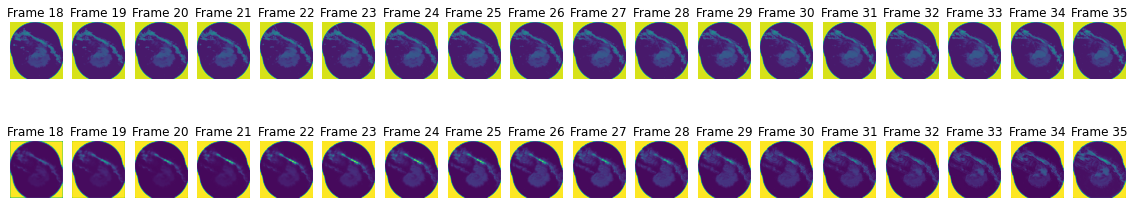

In [ ]:
# reconstructed_model = keras.models.load_model("./drive/MyDrive/model_saved")
# pick a random index from validation dataset
random_index = np.random.choice(range(len(X_val)), size=1)
test_serie_X = X_val[random_index[0]]
test_serie_Y = y_val[random_index[0]]

first_frames = test_serie_X
original_frames = test_serie_Y
# predict the next 18 fames
new_prediction = model.predict(np.expand_dims(first_frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)

fig, axes = plt.subplots(2, 18, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="viridis")
    ax.set_title(f"Frame {idx + 18}")
    ax.axis("off")

# Plot the predicted frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow((new_prediction[idx]).reshape((344,315)), cmap="viridis")
    ax.set_title(f"Frame {idx + 18}")
    ax.axis("off")

# Display the figure.
plt.show()


# Create animated GIFs for original frames

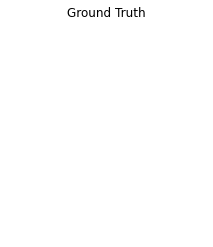

In [ ]:
fig, ax = plt.subplots()
original_images = []
for f in original_frames:
    ax.set_title(f"Ground Truth")
    ax.axis("off")
    crn_f = ax.imshow(np.squeeze(f),cmap='viridis', animated=False)
    original_images.append([crn_f])
animation_originals = animation.ArtistAnimation(fig, original_images, 
                                                interval=100, blit=False, 
                                                repeat_delay=1000)
animation_originals.save('./drive/MyDrive/ground_truth.gif', 
                         writer=animation.PillowWriter(), dpi=100)
HTML(animation_originals.to_html5_video())

# Create animated GIF for predicted frames

18


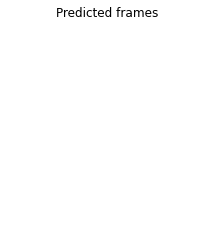

In [ ]:
fig, ax = plt.subplots()
predicted_images = []
for f in new_prediction:
    ax.set_title(f"Ground Truth")
    ax.axis("off")
    crn_f = ax.imshow(np.squeeze(f),cmap='viridis', animated=False)
    ax.set_title(f"Predicted frames")
    predicted_images.append([crn_f])
print(len(predicted_images))
animation_predicted = animation.ArtistAnimation(fig, predicted_images, 
                                                interval=100, blit=False, 
                                                repeat_delay=1000)
animation_predicted.save('./drive/MyDrive/predicted.gif', 
                         writer=animation.PillowWriter(), dpi=100)
HTML(animation_predicted.to_html5_video())